## Part 1: Get data from sources

- 1A: Alpha Vantage API


- 1B: Yahoo Finance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

Define the input symbol. It should received from the user input.

In [3]:
symbol = "TSLA"

Declaration of system configuration

In [71]:
config = {
    "y_finance": {
        "period": "10y", # period to download the data from Yahoo Finance
        "symbol": symbol, # TSLA - Tesla
        "key_adjusted_close": "adj close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.80,
    }, 
    "plots": {
        "show_plots": True,
        "xticks_interval": 90,
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since we are only using 1 feature, close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu", # "cuda" or "cpu"
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

Get the data and save to CSV file

In [72]:
# Get data of a period of recent years
df = yf.download(symbol, period=config['y_finance']['period'])

# Save the data to CSV file
df.to_csv('data/' + symbol + '.csv')

[*********************100%%**********************]  1 of 1 completed


Load data from CSV file for processing

In [73]:
# Loading data from CSV file
df = pd.read_csv('data/' + symbol + '.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500
1,2013-09-10,10.763333,11.166667,10.708667,11.091333,11.091333,134517000
2,2013-09-11,11.094000,11.193333,10.808667,10.901333,10.901333,87487500
3,2013-09-12,10.933333,11.117333,10.700667,10.995333,10.995333,92400000
4,2013-09-13,10.851333,11.091333,10.810667,11.036000,11.036000,81018000


## Part 2: EDA

In [75]:
# Change column names to lower case to process easier in latter parts
df.columns = df.columns.str.lower()

Handle missing values


In [76]:
df.isnull().sum()

date         0
open         0
high         0
low          0
close        0
adj close    0
volume       0
dtype: int64

Note:
- No missing values

Handle duplicated values

In [77]:
duplicated_rows = df.duplicated().sum()
duplicated_rows

0

Note:
- No duplicated values

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       2516 non-null   object 
 1   open       2516 non-null   float64
 2   high       2516 non-null   float64
 3   low        2516 non-null   float64
 4   close      2516 non-null   float64
 5   adj close  2516 non-null   float64
 6   volume     2516 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.7+ KB


Change `date` to index of time series

In [79]:
df.set_index(pd.DatetimeIndex(df['date']), inplace = True)

In [80]:
df.head()

,date,open,high,low,close,adj close,volume
date,,,,,,,
2013-09-09,2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500
2013-09-10,2013-09-10,10.763333,11.166667,10.708667,11.091333,11.091333,134517000
2013-09-11,2013-09-11,11.094000,11.193333,10.808667,10.901333,10.901333,87487500
2013-09-12,2013-09-12,10.933333,11.117333,10.700667,10.995333,10.995333,92400000
2013-09-13,2013-09-13,10.851333,11.091333,10.810667,11.036000,11.036000,81018000


In [81]:
df = df.drop(columns=['date'], axis=1)

In [82]:
num_feats = ['open', 'high', 'low', 'close', 'adj close', 'volume']

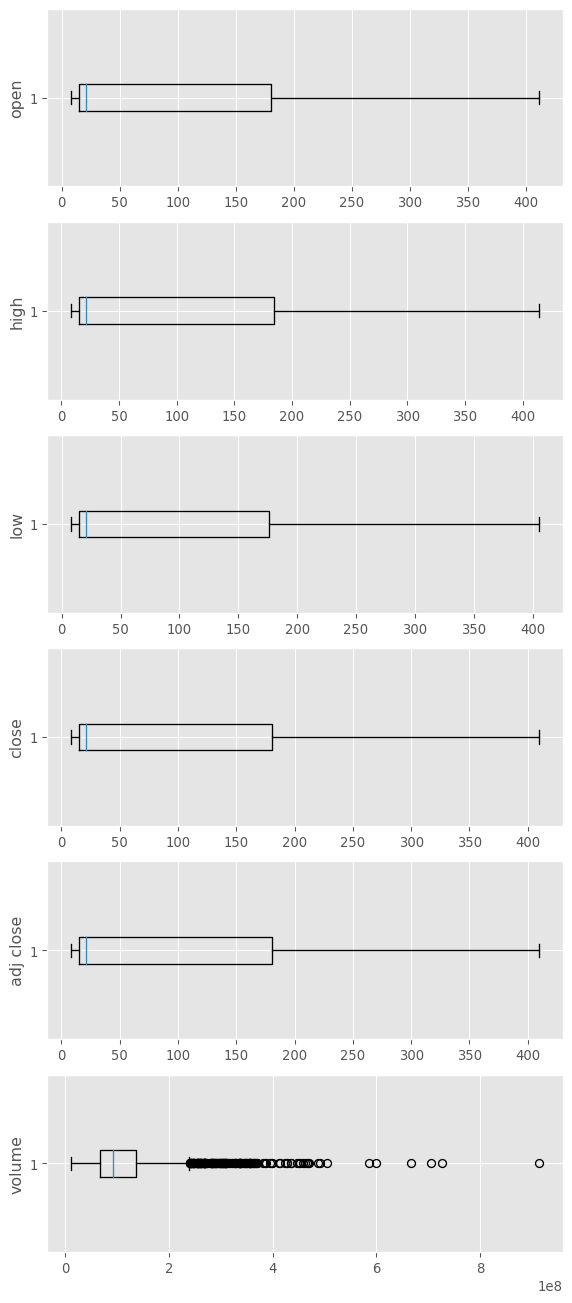

In [83]:
# Box Plots
fig, axs = plt.subplots(len(num_feats),1,dpi=95, figsize=(7,17))
i = 0
for feat in num_feats:
    axs[i].boxplot(df[feat], vert=False)
    axs[i].set_ylabel(feat)
    i+=1

plt.show()

Note:
- We can see that there are bunch of outliers at `Volume` feature

In [84]:
# Function to detect outliers using interquatile
def detect_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    outliers = dataframe[(dataframe[column] < Q1 - 1.5*IQR) | (dataframe[column] > Q3 + 1.5*IQR)]
    return outliers

# Detect and print number of outliers for each feature
for column in num_feats:
    outliers = detect_outliers(df, column)
    print(f'Number of outliers in {column}: {len(outliers)}')

Number of outliers in open: 0
Number of outliers in high: 0
Number of outliers in low: 0
Number of outliers in close: 0
Number of outliers in adj close: 0
Number of outliers in volume: 172


In [85]:
# Function to handle outliers by setting their values into the threshold
def handle_outliers(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5*IQR
    upper_limit = Q3 + 1.5*IQR
    dataframe[column] = dataframe[column].apply(lambda x: upper_limit if x > upper_limit else lower_limit if x < lower_limit else x)

# Handle outliers for each feature
for column in num_feats:
    handle_outliers(df, column)

# Checking the outliers after correct
for column in num_feats:
    outliers = detect_outliers(df, column)
    print(f'Number of outliers in {column}: {len(outliers)}')

Number of outliers in open: 0
Number of outliers in high: 0
Number of outliers in low: 0
Number of outliers in close: 0
Number of outliers in adj close: 0
Number of outliers in volume: 0


Note:
- There is no more outliers in the `volume` feature

In [86]:
df.describe()

,open,high,low,close,adj close,volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,86.738657,88.675696,84.644476,86.712453,86.712453,1.085627e+08
std,106.086706,108.499255,103.405368,105.988067,105.988067,5.683456e+07
min,7.958667,8.181333,7.740000,8.033333,8.033333,1.062000e+07
25%,15.333333,15.569333,15.074167,15.333000,15.333000,6.643185e+07
50%,20.931334,21.241000,20.600000,20.992667,20.992667,9.287385e+07
75%,180.003338,184.440002,176.320000,180.552494,180.552494,1.353589e+08
max,411.470001,414.496674,405.666656,409.970001,409.970001,2.387494e+08


In [87]:
df.shape

(2516, 6)

Summary EDA: 
- There are 1257 data points, each data points has 7 features
- 1 feature is datetime, the other 6 features are numerical
- There are some outliers in `volume` feature, using data cleaning technique to set the value within an appropriate threshold
- There is no missing nor duplicated values

## Part 3. Price Prediction using Regression

In [88]:
import pandas_ta


# Add EMA to dataframe by appending
# Note: pandas_ta integrates seamlessly into
# our existing dataframe
df.ta.ema(close='adj close', length=10, append=True)
df.ta.sma(close='adj close', length=10, append=True)

date
2013-09-09           NaN
2013-09-10           NaN
2013-09-11           NaN
2013-09-12           NaN
2013-09-13           NaN
                 ...    
2023-08-30    235.756999
2023-08-31    239.642998
2023-09-01    242.594997
2023-09-05    245.115996
2023-09-06    246.988995
Name: SMA_10, Length: 2516, dtype: float64

In [89]:
df

,open,high,low,close,adj close,volume,EMA_10,SMA_10
date,,,,,,,,
2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500.0,NaN,NaN
2013-09-10,10.763333,11.166667,10.708667,11.091333,11.091333,134517000.0,NaN,NaN
2013-09-11,11.094000,11.193333,10.808667,10.901333,10.901333,87487500.0,NaN,NaN
2013-09-12,10.933333,11.117333,10.700667,10.995333,10.995333,92400000.0,NaN,NaN
2013-09-13,10.851333,11.091333,10.810667,11.036000,11.036000,81018000.0,NaN,NaN
...,...,...,...,...,...,...,...,...
2023-08-30,254.199997,260.510010,250.589996,256.899994,256.899994,121988400.0,242.387002,235.756999
2023-08-31,255.979996,261.179993,255.050003,258.079987,258.079987,108861700.0,245.240272,239.642998
2023-09-01,257.260010,259.079987,242.009995,245.009995,245.009995,132272500.0,245.198403,242.594997


In [90]:
# Drop the first n-rows
df = df.iloc[10:]
# View our newly-formed dataset
print(df.head(10))

                 open       high        low      close  adj close  \
date                                                                
2013-09-23  12.298667  12.365333  11.807333  12.074000  12.074000   
2013-09-24  11.942667  12.330667  11.843333  12.155333  12.155333   
2013-09-25  12.237333  12.420000  12.033333  12.349333  12.349333   
2013-09-26  12.446667  12.645333  12.374000  12.576000  12.576000   
2013-09-27  12.501333  12.752000  12.428667  12.726667  12.726667   
2013-09-30  12.600000  12.966667  12.533333  12.891333  12.891333   
2013-10-01  12.930667  12.948667  12.558000  12.866667  12.866667   
2013-10-02  12.572667  12.788667  11.693333  12.063333  12.063333   
2013-10-03  11.670000  11.979333  11.200000  11.554000  11.554000   
2013-10-04  11.760000  12.078667  11.510000  12.065333  12.065333   

                 volume     EMA_10     SMA_10  
date                                           
2013-09-23  122601000.0  11.366545  11.345400  
2013-09-24   94101000.0  11

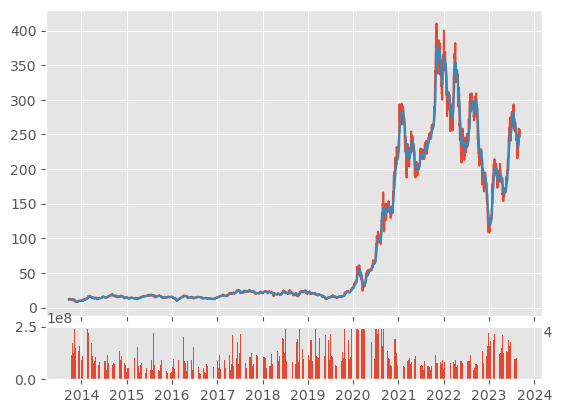

In [91]:
from matplotlib import style
style.use('ggplot')

ax1 = plt.subplot2grid((6,1),(0,0),rowspan=5,colspan=1)
ax2 = plt.subplot2grid((6,1),(5,0),rowspan=1,colspan=1,sharex=ax1)
ax1.plot(df.index,df['adj close'])
ax1.plot(df.index,df['EMA_10'])
ax2.bar(df.index,df['volume'])

plt.show()

## Feature Engineering

In [63]:
# Create a Data Frame for regression model
# dfreg = df.loc[:,['adj close','volume']]
# dfreg['hl_pct'] = (df['high'] - df['low']) / df['close'] * 100.0
# dfreg['hct_change'] = (df['close'] - df['open']) / df['open'] * 100.0
# dfreg.head()

,adj close,volume,hl_pct,hct_change
date,,,,
2018-09-07,17.549334,287259750.0,6.116083,1.207228
2018-09-10,19.033333,214252500.0,5.264443,4.479251
2018-09-11,18.629333,137550000.0,3.023896,-0.010729
2018-09-12,19.369333,150231000.0,4.766980,3.233371
2018-09-13,19.297333,95104500.0,3.392535,0.499969


In [92]:
dfreg = df.loc[:,['adj close','volume', 'EMA_10', 'SMA_10']]
dfreg.head()

,adj close,volume,EMA_10,SMA_10
date,,,,
2013-09-23,12.074000,122601000.0,11.366545,11.345400
2013-09-24,12.155333,94101000.0,11.509961,11.451800
2013-09-25,12.349333,123790500.0,11.662574,11.596600
2013-09-26,12.576000,99216000.0,11.828652,11.754667
2013-09-27,12.726667,88746000.0,11.991927,11.923733


In [55]:
df.shape

(1247, 8)

In [56]:
dfreg.shape

(1247, 4)

### Pre-processing & Cross Validation

Drop missing value

Separating the label here, we want to predict the AdjClose

Scale the X so that everyone can have the same distribution for linear regression

Finally We want to find Data Series of late X and early X (train) for model generation and evaluation

Separate label and identify it as y

Separation of training and testing of model by cross validation train test split

In [93]:
import math
import numpy as np
from sklearn import preprocessing, svm

# Drop missing value
dfreg.fillna(value=-99999, inplace=True)

# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))

# Separating the label here, we want to predict the adj close
forecast_col = 'adj close'
dfreg['target'] = dfreg[forecast_col].shift(-forecast_out)
print(dfreg['target'])
X = np.array(dfreg.drop(['target'], axis=1))

# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)

# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Separate label and identify it as y
y = np.array(dfreg['target'])
y = y[:-forecast_out]

print('Dimension of X',X.shape)
print('Dimension of y',y.shape)

date
2013-09-23    10.964667
2013-09-24    10.614667
2013-09-25    10.662667
2013-09-26    10.811333
2013-09-27    11.680000
                ...    
2023-08-30          NaN
2023-08-31          NaN
2023-09-01          NaN
2023-09-05          NaN
2023-09-06          NaN
Name: target, Length: 2506, dtype: float64
Dimension of X (2480, 4)
Dimension of y (2480,)


In [94]:
print(X_lately)

[[ 1.64094715 -0.44546408  1.70382964  1.70117466]
 [ 1.57533042 -0.11822368  1.68258585  1.66601927]
 [ 1.62444871 -0.19188353  1.67417841  1.66263149]
 [ 1.5729735  -0.16241994  1.65789515  1.65680224]
 [ 1.55025275  0.04630411  1.64042143  1.64013773]
 [ 1.53375431 -0.20820251  1.6231105   1.62539423]
 [ 1.46295247 -0.12098077  1.59601162  1.60442402]
 [ 1.49264961  0.01814688  1.57926544  1.59461078]
 [ 1.46728912 -0.16903979  1.56093068  1.57209808]
 [ 1.44004313 -0.17381629  1.54095172  1.5459137 ]
 [ 1.375935   -0.35687788  1.51289282  1.51931295]
 [ 1.30654725  0.07071655  1.4772585   1.49233368]
 [ 1.2463986   0.21568234  1.43711406  1.45438667]
 [ 1.21123338  0.48144974  1.39784398  1.41807679]
 [ 1.36009642  0.47949547  1.39291099  1.39898974]
 [ 1.37810333  0.38962052  1.39216474  1.38336618]
 [ 1.4127029  -0.13011299  1.39787547  1.37832235]
 [ 1.34840604 -0.15300427  1.39080093  1.36384382]
 [ 1.42901275 -0.03267099  1.39973942  1.3600018 ]
 [ 1.43118123 -0.01398225  1.40

In [95]:
from sklearn.model_selection import train_test_split
# Separation of training and testing of model by cross validation train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Model Generation

To predict the return of the stocks in the next period - Prediction analysis

- Simple Linear Analysis
- Quadratic Linear Analysis (QDA)
- K Nearest Neighbor (KNN

In [96]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Linear regression
clf_reg = LinearRegression(n_jobs=-1)
clf_reg.fit(X_train, y_train)


# Quadratic Regression 2
clf_poly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clf_poly2.fit(X_train, y_train)

# Quadratic Regression 3
clf_poly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clf_poly3.fit(X_train, y_train)
    
# KNN Regression
clf_knn = KNeighborsRegressor(n_neighbors=2)
clf_knn.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=2)

In [97]:
confidence_reg = clf_reg.score(X_test, y_test)
confidence_poly2 = clf_poly2.score(X_test,y_test)
confidence_poly3 = clf_poly3.score(X_test,y_test)
confidence_knn = clf_knn.score(X_test, y_test)

print("The linear regression confidence is ",confidence_reg)
print("The quadratic regression 2 confidence is ",confidence_poly2)
print("The quadratic regression 3 confidence is ",confidence_poly3)
print("The knn regression confidence is ",confidence_knn)

The linear regression confidence is  0.9216894845211454
The quadratic regression 2 confidence is  0.9380578594471843
The quadratic regression 3 confidence is  0.9412187357403867
The knn regression confidence is  0.9447376164212146


In [98]:
# Printing the forecast
forecast_set = clf_reg.predict(X_lately)
dfreg['forecast'] = np.nan
print(forecast_set, confidence_reg, forecast_out)

[259.55330389 256.81382316 259.83796098 253.76604989 252.18289811
 249.12700201 242.05048388 243.79795244 241.19291817 239.3784734
 232.50225197 226.31295817 220.68495046 217.54645657 232.14856289
 235.46457081 238.09321538 233.46841541 242.78434657 244.41770115
 263.76182732 263.43314308 262.60538553 249.60169104 258.35095235
 252.53529021] 0.9216894845211454 26


In [99]:
dfreg.tail(20)

,adj close,volume,EMA_10,SMA_10,target,forecast
date,,,,,,
2023-08-09,242.190002,101596300.0,255.062445,256.128001,NaN,NaN
2023-08-10,245.339996,109498600.0,253.294727,255.091000,NaN,NaN
2023-08-11,242.649994,98866600.0,251.359321,252.712000,NaN,NaN
2023-08-14,239.759995,98595300.0,249.250353,249.945000,NaN,NaN
2023-08-15,232.960007,88197600.0,246.288471,247.134000,NaN,NaN
2023-08-16,225.600006,112484500.0,242.526932,244.283000,NaN,NaN
2023-08-17,219.220001,120718400.0,238.289308,240.273000,NaN,NaN
2023-08-18,215.490005,135813700.0,234.143981,236.436000,NaN,NaN
2023-08-21,231.279999,135702700.0,233.623257,234.419000,NaN,NaN


## Plotting the Prediction

In [100]:
from datetime import datetime as dt, timedelta

last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]

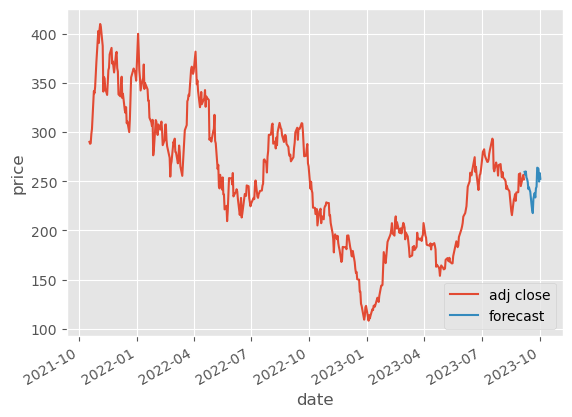

In [102]:
dfreg['adj close'].tail(500).plot()
dfreg['forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('date')
plt.ylabel('price')
plt.show()

In [104]:
dfreg.tail(30)

,adj close,volume,EMA_10,SMA_10,target,forecast
date,,,,,,
2023-08-31,258.079987,108861700.0,245.240272,239.642998,NaN,NaN
2023-09-01,245.009995,132272500.0,245.198403,242.594997,NaN,NaN
2023-09-05,256.489990,129469600.0,247.251419,245.115996,NaN,NaN
2023-09-06,251.919998,115853587.0,248.100252,246.988995,NaN,NaN
2023-09-07,NaN,NaN,NaN,NaN,NaN,259.553304
2023-09-08,NaN,NaN,NaN,NaN,NaN,256.813823
2023-09-09,NaN,NaN,NaN,NaN,NaN,259.837961
2023-09-10,NaN,NaN,NaN,NaN,NaN,253.766050
2023-09-11,NaN,NaN,NaN,NaN,NaN,252.182898


## Part 4. Prediction Using LSTM : A Time-Series model

In [ ]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df

,date,open,high,low,close,adj close,volume
date,,,,,,,
2013-09-03,2013-09-03,11.560000,11.580000,11.093333,11.262667,11.262667,180916500.0
2013-09-04,2013-09-04,11.318000,11.441333,11.037333,11.374667,11.374667,172135500.0
2013-09-05,2013-09-05,11.340000,11.433333,11.216667,11.328667,11.328667,100279500.0
2013-09-06,2013-09-06,11.238000,11.313333,11.010000,11.131333,11.131333,129295500.0
2013-09-09,2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500.0
...,...,...,...,...,...,...,...
2023-08-28,2023-08-28,242.580002,244.380005,235.350006,238.820007,238.820007,107673700.0
2023-08-29,2023-08-29,238.580002,257.480011,237.770004,257.179993,257.179993,134047600.0
2023-08-30,2023-08-30,254.199997,260.510010,250.589996,256.899994,256.899994,121988400.0


#### Data Visualization

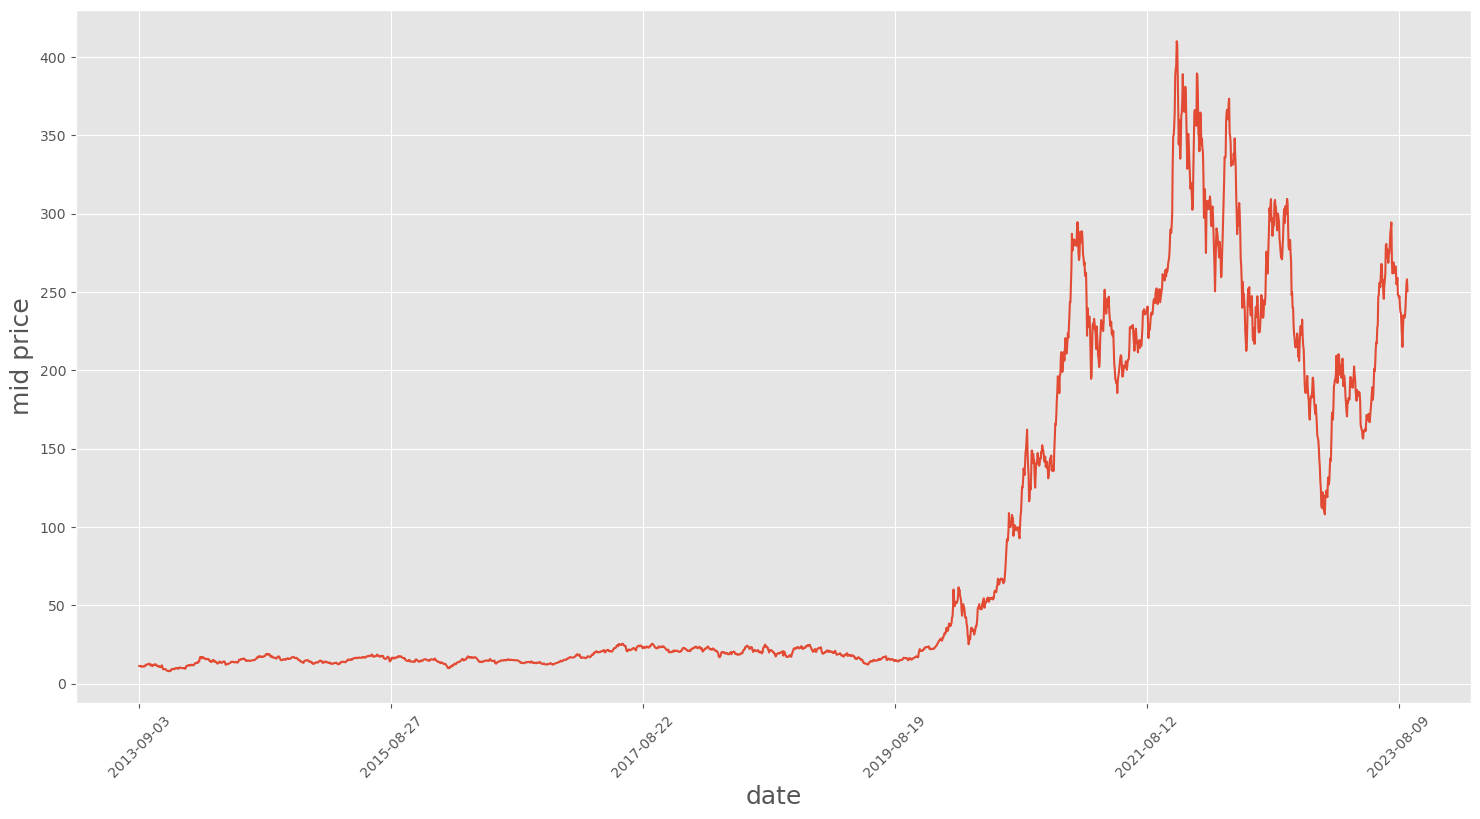

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['low']+df['high'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['date'].loc[::500],rotation=45)
plt.xlabel('date',fontsize=18)
plt.ylabel('mid price',fontsize=18)
plt.show()

Splitting Data into a Training set and a Test set

In [ ]:
# First calculate the mid prices from the highest and lowest
# high_prices = df.loc[:,'High'].as_matrix()
# low_prices = df.loc[:,'Low'].as_matrix()
# as_matrix() was depreciated after version 0.23.0. Use df.values instead
high_prices = df.loc[:,'high'].values
low_prices = df.loc[:,'low'].values
mid_prices = (high_prices+low_prices)/2.0

In [ ]:
len(mid_prices)

2518

In [ ]:
train_data = mid_prices[:2100]
test_data = mid_prices[2100:]

Normalizing the Data

In [ ]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [ ]:
# Train the Scaler with training data and smooth data
# 1500 + 600 = 2100 (train-data-size)
smoothing_window_size = 600
for di in range(0,1500,smoothing_window_size):
    # print(di)
    # print(di+smoothing_window_size)
    # # print(train_data[di:di+smoothing_window_size,:])
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])

In [ ]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

In [ ]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(2100):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

One-Step Ahead Prediction via Averaging

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df

,date,open,high,low,close,adj close,volume
0,2013-09-03,11.560000,11.580000,11.093333,11.262667,11.262667,180916500.0
1,2013-09-04,11.318000,11.441333,11.037333,11.374667,11.374667,172135500.0
2,2013-09-05,11.340000,11.433333,11.216667,11.328667,11.328667,100279500.0
3,2013-09-06,11.238000,11.313333,11.010000,11.131333,11.131333,129295500.0
4,2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500.0
...,...,...,...,...,...,...,...
2513,2023-08-28,242.580002,244.380005,235.350006,238.820007,238.820007,107673700.0
2514,2023-08-29,238.580002,257.480011,237.770004,257.179993,257.179993,134047600.0
2515,2023-08-30,254.199997,260.510010,250.589996,256.899994,256.899994,121988400.0
2516,2023-08-31,255.979996,261.179993,255.050003,258.079987,258.079987,108861700.0


In [ ]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.01633


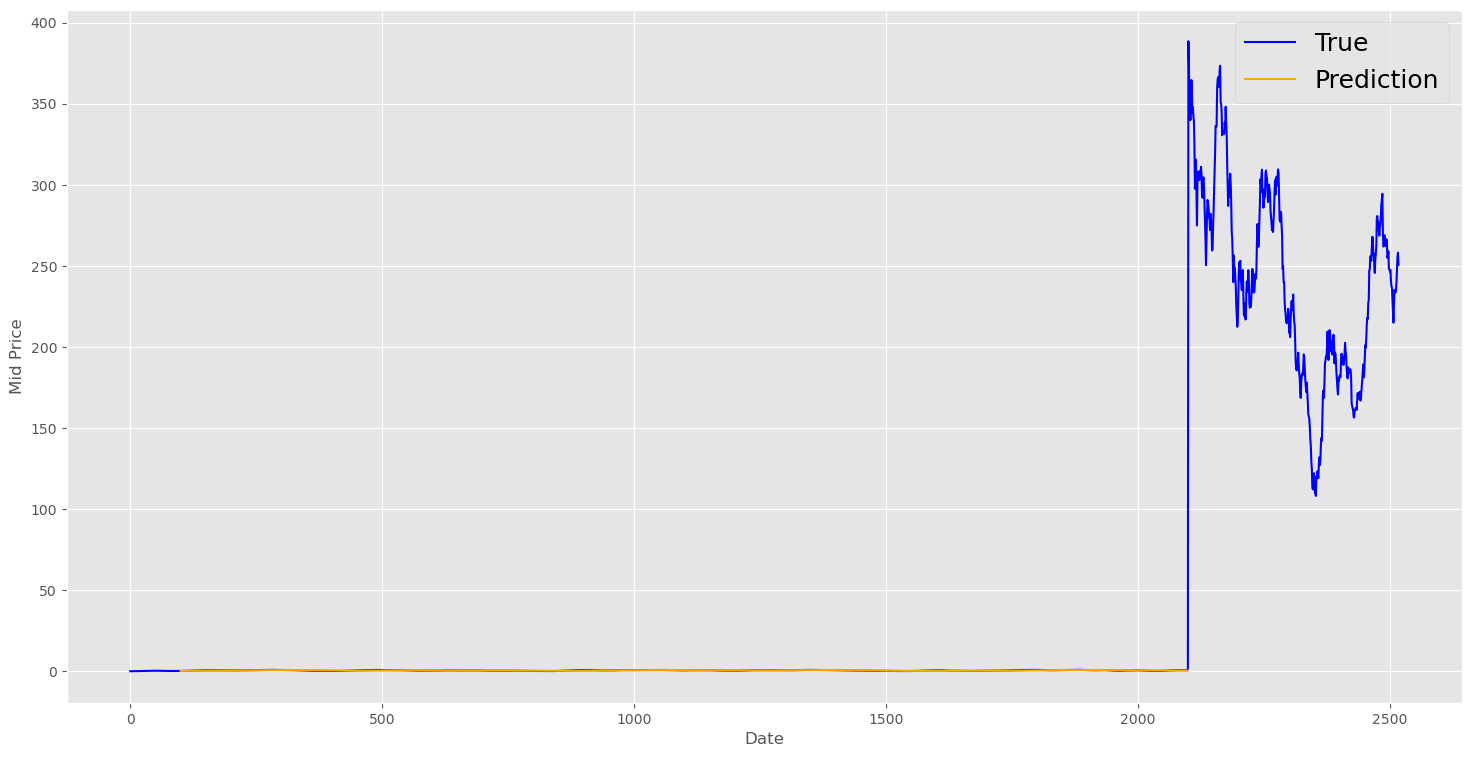

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

Exponential Moving Average

In [ ]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00010


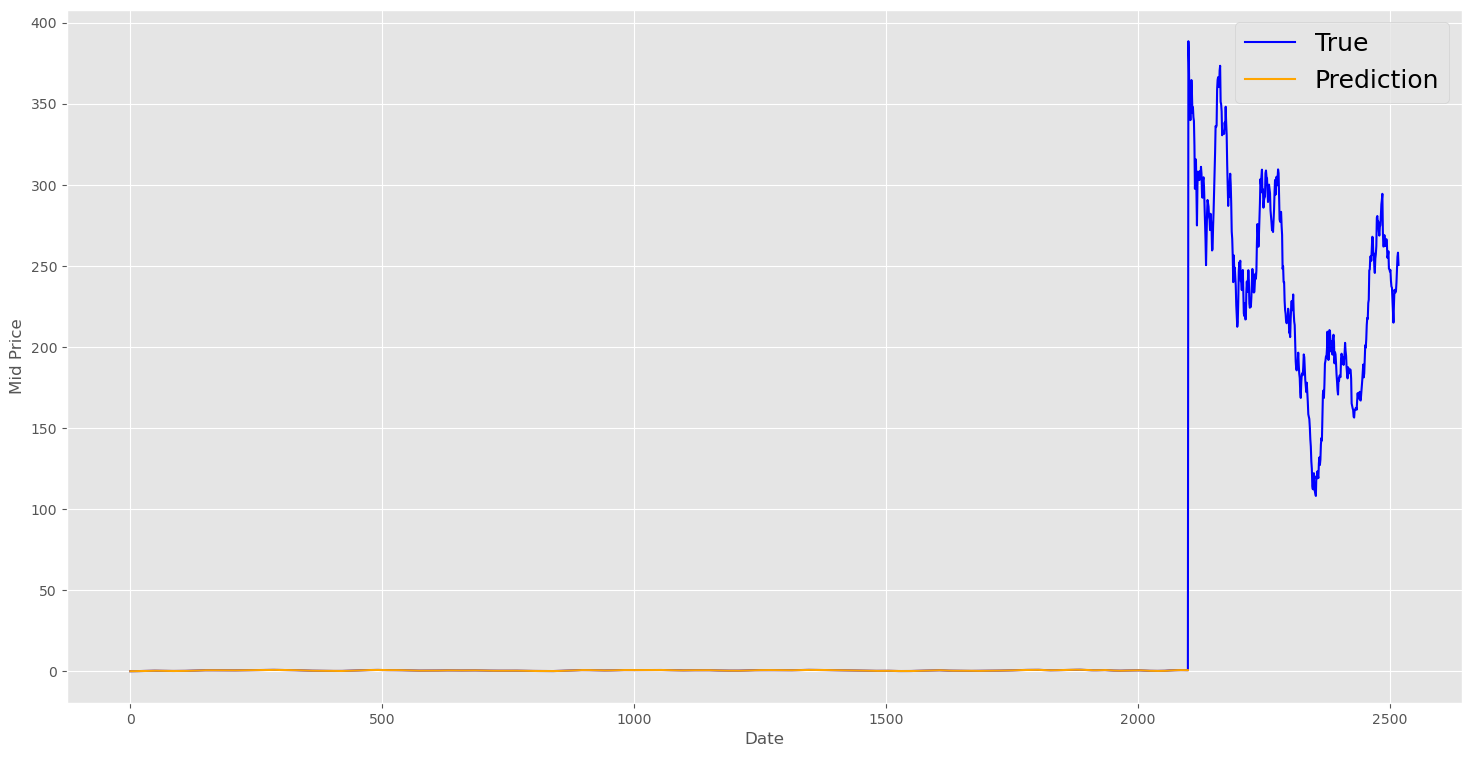

In [ ]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

Introduction to LSTMs: Making Stock Movement Predictions Far into the Future

In [ ]:

# class DataGeneratorSeq(object):

#     def __init__(self,prices,batch_size,num_unroll):
#         self._prices = prices
#         self._prices_length = len(self._prices) - num_unroll
#         self._batch_size = batch_size
#         self._num_unroll = num_unroll
#         self._segments = self._prices_length //self._batch_size
#         self._cursor = [offset * self._segments for offset in range(self._batch_size)]

#     def next_batch(self):

#         batch_data = np.zeros((self._batch_size),dtype=np.float32)
#         batch_labels = np.zeros((self._batch_size),dtype=np.float32)

#         for b in range(self._batch_size):
#             if self._cursor[b]+1>=self._prices_length:
#                 #self._cursor[b] = b * self._segments
#                 self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

#             batch_data[b] = self._prices[self._cursor[b]]
#             batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

#             self._cursor[b] = (self._cursor[b]+1)%self._prices_length

#         return batch_data,batch_labels

#     def unroll_batches(self):

#         unroll_data,unroll_labels = [],[]
#         init_data, init_label = None,None
#         for ui in range(self._num_unroll):

#             data, labels = self.next_batch()    

#             unroll_data.append(data)
#             unroll_labels.append(labels)

#         return unroll_data, unroll_labels

#     def reset_indices(self):
#         for b in range(self._batch_size):
#             self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



# dg = DataGeneratorSeq(train_data,5,5)
# u_data, u_labels = dg.unroll_batches()

# for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
#     print('\n\nUnrolled index %d'%ui)
#     dat_ind = dat
#     lbl_ind = lbl
#     print('\tInputs: ',dat )
#     print('\n\tOutput:',lbl)



Unrolled index 0
	Inputs:  [3.0414420e-04 1.6229260e-01 9.7497307e-02 7.0530045e-01 2.0041822e-01]

	Output: [0.00257875 0.17359716 0.11786661 0.71075433 0.20041822]


Unrolled index 1
	Inputs:  [0.00111656 0.16762987 0.10178127 0.707424   0.20358567]

	Output: [0.00111656 0.16762987 0.12434145 0.71068394 0.21547401]


Unrolled index 2
	Inputs:  [0.00257875 0.17359716 0.10660312 0.7090746  0.206551  ]

	Output: [0.01550044 0.17359716 0.11786661 0.7102101  0.21848558]


Unrolled index 3
	Inputs:  [0.00475947 0.18010038 0.11196046 0.7102101  0.2095476 ]

	Output: [0.00475947 0.20282295 0.11786661 0.7102101  0.2095476 ]


Unrolled index 4
	Inputs:  [0.007651   0.18713206 0.11786661 0.71075433 0.21251689]

	Output: [0.01550044 0.21152663 0.13901654 0.70986915 0.21848558]


Defining Hyperparameters

In [ ]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

tf.compat.v1.reset_default_graph() # This is important in case you run this multiple times

Defining Inputs and Outputs

In [ ]:
# tf.disable_v2_behavior()

# Input data.
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.compat.v1.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))

In [ ]:
lstm_cells = [
    # tf.contrib.rnn.LSTMCell(num_units=num_nodes[li],
    #                         state_is_tuple=True,
    #                         initializer= tf.contrib.layers.xavier_initializer()
    #                        )
    tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=num_nodes[li],
                            state_is_tuple=True,
                            initializer= tf.initializers.GlorotUniform()
                           )
 for li in range(n_layers)]

# drop_lstm_cells = [tf.contrib.rnn.DropoutWrapper(
#     lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
# ) for lstm in lstm_cells]
drop_lstm_cells = [tf.compat.v1.nn.rnn_cell.DropoutWrapper(
     lstm, input_keep_prob=1.0,output_keep_prob=1.0-dropout, state_keep_prob=1.0-dropout
) for lstm in lstm_cells]
# drop_multi_cell = tf.contrib.rnn.MultiRNNCell(drop_lstm_cells)
drop_multi_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(drop_lstm_cells)
# multi_cell = tf.contrib.rnn.MultiRNNCell(lstm_cells)
multi_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(lstm_cells)

# w = tf.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.contrib.layers.xavier_initializer())
w = tf.compat.v1.get_variable('w',shape=[num_nodes[-1], 1], initializer=tf.keras.initializers.GlorotUniform())
b = tf.compat.v1.get_variable('b',initializer=tf.random.uniform([1],-0.1,0.1))

C:\Users\thong.lam\AppData\Local\Temp\ipykernel_18408\554334990.py:6: UserWarning:

`tf.nn.rnn_cell.LSTMCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.LSTMCell`, and will be replaced by that in Tensorflow 2.0.



ValueError: Variable w already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\tensorflow\python\framework\ops.py", line 3381, in _create_op_internal
    ret = Operation.from_node_def(
  File "c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\tensorflow\python\framework\op_def_library.py", line 795, in _apply_op_helper
    op = g._create_op_internal(op_type_name, inputs, dtypes=None,
  File "c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\tensorflow\python\ops\gen_state_ops.py", line 2184, in variable_v2
    _, _, _op, _outputs = _op_def_library._apply_op_helper(
  File "c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\tensorflow\python\ops\state_ops.py", line 70, in variable_op_v2
    return gen_state_ops.variable_v2(
  File "c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\tensorflow\python\ops\ref_variable.py", line 410, in _init_from_args
    self._variable = state_ops.variable_op_v2(


## Part 5. Calculating Support & Resistance in Python using K-Means Clustering

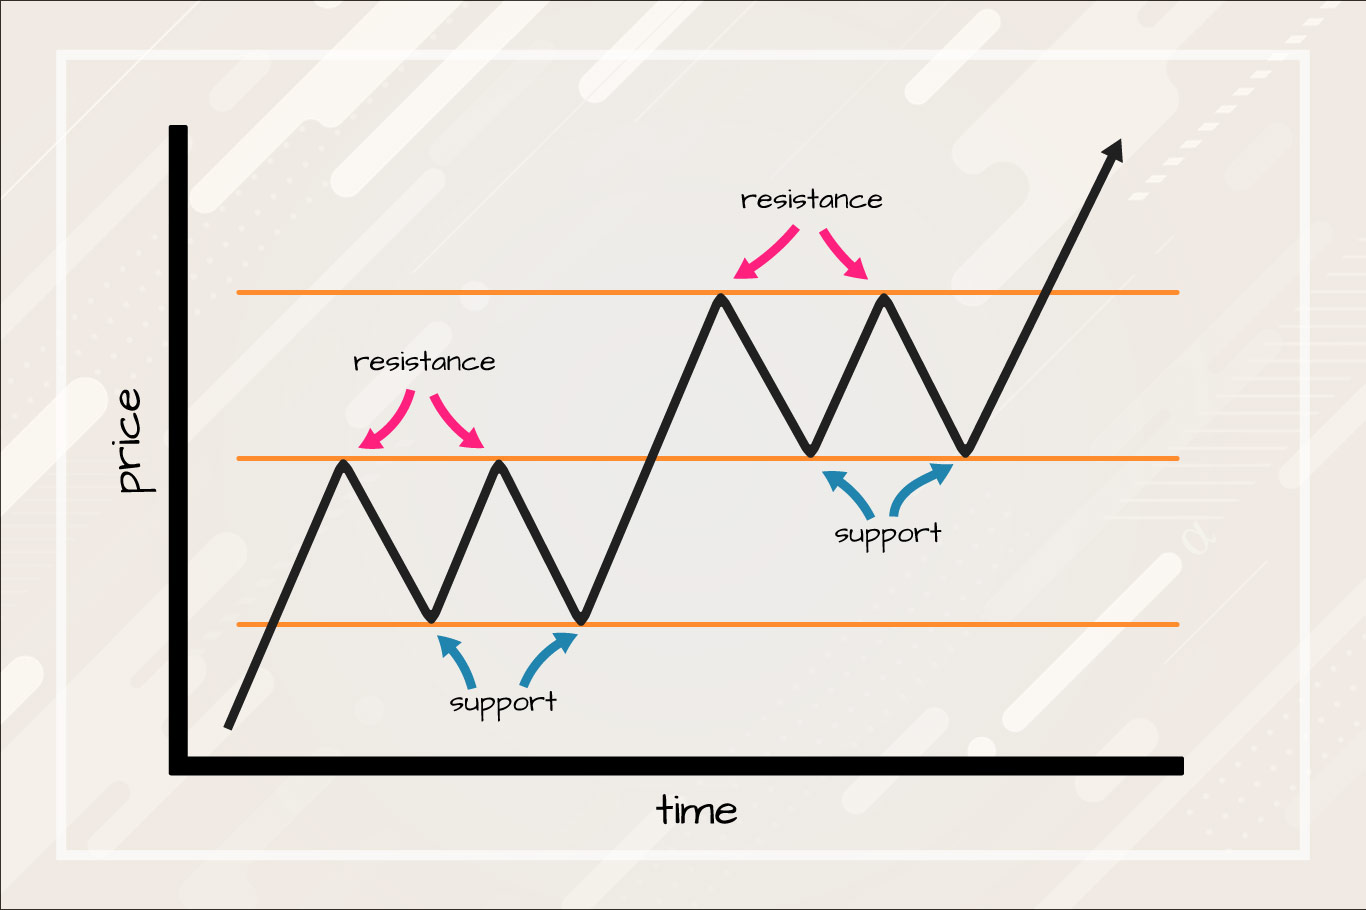

In [ ]:
df = df.set_index('date')

In [ ]:
from sklearn.cluster import KMeans

# Convert adjusted closing price to numpy array
symbol_prices = np.array(df["adj close"])
print("Symbol Prices:\n", symbol_prices)
# Perform cluster analysis
K = 6
kmeans = KMeans(n_clusters=6).fit(symbol_prices.reshape(-1, 1))
# predict which cluster each price is in
clusters = kmeans.predict(symbol_prices.reshape(-1, 1))
print("Clusters:\n", clusters)

Symbol Prices:
 [ 11.2626667   11.37466717  11.32866669 ... 256.8999939  258.07998657
 245.00999451]


c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Clusters:
 [0 0 0 ... 1 1 1]


In [ ]:
df

,open,high,low,close,adj close,volume
date,,,,,,
2013-09-03,11.560000,11.580000,11.093333,11.262667,11.262667,180916500.0
2013-09-04,11.318000,11.441333,11.037333,11.374667,11.374667,172135500.0
2013-09-05,11.340000,11.433333,11.216667,11.328667,11.328667,100279500.0
2013-09-06,11.238000,11.313333,11.010000,11.131333,11.131333,129295500.0
2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500.0
...,...,...,...,...,...,...
2023-08-28,242.580002,244.380005,235.350006,238.820007,238.820007,107673700.0
2023-08-29,238.580002,257.480011,237.770004,257.179993,257.179993,134047600.0
2023-08-30,254.199997,260.510010,250.589996,256.899994,256.899994,121988400.0


In [ ]:
import plotly.graph_objects as go

# Assigns plotly as visualization engine
pd.options.plotting.backend = 'plotly'
# Arbitrarily 6 colors for our 6 clusters
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo']
# Create Scatter plot, assigning each point a color based
# on it's grouping where group_number == index of color.
fig = df.plot.scatter(
    x=df.index,
    y="adj close",
    color=[colors[i] for i in clusters],
)
# Configure some styles
layout = go.Layout(
    plot_bgcolor='#efefef',
    showlegend=False,
    # Font Families
    font_family='Monospace',
    font_color='#000000',
    font_size=20,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        ))
)
fig.update_layout(layout)
# Display plot in local browser window
fig.show()

Find Cluster Minimum & Maximum Values

In [ ]:
# Create list to hold values, initialized with infinite values
min_max_values = []
# init for each cluster group
for i in range(6):
    # Add values for which no price could be greater or less
    min_max_values.append([np.inf, -np.inf])
# Print initial values
print(min_max_values)
# Get min/max for each cluster
for i in range(len(symbol_prices)):
    # Get cluster assigned to price
    cluster = clusters[i]
    # Compare for min value
    if symbol_prices[i] < min_max_values[cluster][0]:
        min_max_values[cluster][0] = symbol_prices[i]
    # Compare for max value
    if symbol_prices[i] > min_max_values[cluster][1]:
        min_max_values[cluster][1] = symbol_prices[i]
# Print resulting values
print(min_max_values)

[[inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf]]
[[8.033332824707031, 71.98733520507812], [213.1000061035156, 260.5400085449219], [74.64199829101562, 157.6699981689453], [322.1366577148437, 409.9700012207031], [260.9166564941406, 319.5033264160156], [158.35000610351562, 211.8733367919922]]


In [ ]:
import plotly.graph_objects as go
# Again, assign an arbitrary color to each of the 6 clusters
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'indigo']
# Create Scatter plot, assigning each point a color where
# point group = color index.
fig = df.plot.scatter(
    x=df.index,
    y="adj close",
    color=[colors[i] for i in clusters],
)

# fig = go.Figure(
#     data=go.Scatter(x=df.index,y=df['adj close'], mode='lines+markers')
#     # color=[colors[i] for i in clusters],
#     )
# Add horizontal lines
for cluster_min, cluster_max in min_max_values:
    fig.add_hline(y=cluster_min, line_width=1, line_color="blue")
    fig.add_hline(y=cluster_max, line_width=1, line_color="blue")
# Add a trace of the price for better clarity
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['adj close'],
    line_color="black",
    line_width=1
))
# Make it pretty
layout = go.Layout(
    plot_bgcolor='#efefef',
    showlegend=False,
    # Font Families
    font_family='Monospace',
    font_color='#000000',
    font_size=20,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        ))
)
fig.update_layout(layout)
fig.show()

Consolidating Boundary Lines

In [ ]:
print("Initial Min/Max Values:\n", min_max_values)
# Create container for combined values
output = []
# Sort based on cluster minimum
s = sorted(min_max_values, key=lambda x: x[0])
# For each cluster get average of
for i, (_min, _max) in enumerate(s):
    # Append min from first cluster
    if i == 0:
        output.append(_min)
    # Append max from last cluster
    if i == len(min_max_values) - 1:
        output.append(_max)
    # Append average from cluster and adjacent for all others
    else:
        output.append(sum([_max, s[i+1][0]]) / 2)
print("Sorted Min/Max Values:\n", output)

Initial Min/Max Values:
 [[8.033332824707031, 71.98733520507812], [213.1000061035156, 260.5400085449219], [74.64199829101562, 157.6699981689453], [322.1366577148437, 409.9700012207031], [260.9166564941406, 319.5033264160156], [158.35000610351562, 211.8733367919922]]
Sorted Min/Max Values:
 [8.033332824707031, 73.31466674804688, 158.01000213623047, 212.4866714477539, 260.72833251953125, 320.8199920654297, 409.9700012207031]


In [ ]:
# Add horizontal lines
for cluster_avg in output:
    fig.add_hline(y=cluster_avg, line_width=1, line_color="blue")

In [ ]:
fig.show()

Assessing Absolute Minima/Maxima

In [ ]:
# Add horizontal lines 
for cluster_avg in output[1:-1]:
    fig.add_hline(y=cluster_avg, line_width=1, line_color="blue")

Determining the Right Number of Cluster

In [ ]:
# create a list to contain output values
values = []
# Define a range of cluster values to assess
K = range(1, 10)
# Performa a clustering using each value, save inertia_ value from each
for k in K:
    kmeans_n = KMeans(n_clusters=k)
    kmeans_n.fit(symbol_prices.reshape(-1, 1))
    values.append(kmeans_n.inertia_)


c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\thong.lam\AppData\Local\anacond

In [ ]:
import plotly.graph_objects as go
# Create initial figure
fig = go.Figure()
# Add line plot of inertia values
fig.add_trace(go.Trace(
    x=list(K),
    y=values,
    line_color="black",
    line_width=1
))
# Make it pretty
layout = go.Layout(
    plot_bgcolor='#efefef',
    showlegend=False,
    # Font Families
    font_family='Monospace',
    font_color='#000000',
    font_size=20,
    xaxis=dict(
        rangeslider=dict(
            visible=False
        ))
)
fig.update_layout(layout)
fig.show()

c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\plotly\graph_objs\_deprecations.py:687: DeprecationWarning:

plotly.graph_objs.Trace is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




## LSTM

In [ ]:
df

,open,high,low,close,adj close,volume
date,,,,,,
2013-09-03,11.560000,11.580000,11.093333,11.262667,11.262667,180916500.0
2013-09-04,11.318000,11.441333,11.037333,11.374667,11.374667,172135500.0
2013-09-05,11.340000,11.433333,11.216667,11.328667,11.328667,100279500.0
2013-09-06,11.238000,11.313333,11.010000,11.131333,11.131333,129295500.0
2013-09-09,10.874667,10.966667,10.567333,10.713333,10.713333,215167500.0
...,...,...,...,...,...,...
2023-08-28,242.580002,244.380005,235.350006,238.820007,238.820007,107673700.0
2023-08-29,238.580002,257.480011,237.770004,257.179993,257.179993,134047600.0
2023-08-30,254.199997,260.510010,250.589996,256.899994,256.899994,121988400.0


In [ ]:
training_set = df.iloc[:1600, 1:2].values
test_set = df.iloc[1600:, 1:2].values

In [ ]:
print(training_set)

[[11.57999992]
 [11.44133282]
 [11.4333334 ]
 [11.31333256]
 [10.96666718]
 [11.16666698]
 [11.19333267]
 [11.11733341]
 [11.09133339]
 [11.39000034]
 [11.22799969]
 [11.16333294]
 [12.03133297]
 [12.38866711]
 [12.3653326 ]
 [12.33066654]
 [12.42000008]
 [12.64533329]
 [12.75199986]
 [12.96666718]
 [12.94866657]
 [12.78866673]
 [11.97933292]
 [12.07866669]
 [12.44866657]
 [12.39533329]
 [11.66600037]
 [11.71666718]
 [11.95266724]
 [12.16666698]
 [12.58600044]
 [12.48666668]
 [12.31999969]
 [12.39733315]
 [12.22599983]
 [11.85200024]
 [11.45400047]
 [11.63333321]
 [11.63333321]
 [11.36666679]
 [11.02999973]
 [11.17866707]
 [10.82933331]
 [11.06000042]
 [11.69266701]
 [12.0953331 ]
 [10.71533298]
 [ 9.71000004]
 [ 9.37333298]
 [ 9.69466686]
 [ 9.64666653]
 [ 9.49133301]
 [ 9.35999966]
 [ 9.19666672]
 [ 9.02999973]
 [ 8.60000038]
 [ 8.49666691]
 [ 8.31933308]
 [ 8.1833334 ]
 [ 8.38933277]
 [ 8.18133259]
 [ 8.46333313]
 [ 8.70600033]
 [ 8.56999969]
 [ 9.66266727]
 [ 9.62866688]
 [ 9.55666

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, 1600):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#(740, 60, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Train on 1540 samples
Epoch 1/100
1540/1540 [==============================] - 10s 7ms/sample - loss: 0.0188
Epoch 2/100
1540/1540 [==============================] - 8s 5ms/sample - loss: 0.0064
Epoch 3/100
1540/1540 [==============================] - 8s 5ms/sample - loss: 0.0061
Epoch 4/100
1540/1540 [==============================] - 8s 5ms/sample - loss: 0.0049
Epoch 5/100
1540/1540 [==============================] - 8s 5ms/sample - loss: 0.0048
Epoch 6/100
1540/1540 [==============================] - 8s 5ms/sample - loss: 0.0051
Epoch 7/100
1540/1540 [==============================] - 8s 5ms/sample - loss: 0.0043
Epoch 8/100
1540/1540 [==============================] - 7s 5ms/sample - loss: 0.0039
Epoch 9/100
1540/1540 [==============================] - 7s 4ms/sample - loss: 0.0039
Epoch 10/100
1540/1540 [==============================] - 6s 4ms/sample - loss: 0.0037
Epoch 11/100
1540/1540 [==============================] - 6s 4ms/sample - loss: 0.0031
Epoch 12/100
1540/1540 [=====

In [ ]:
# Getting the predicted stock price of 2017
dataset_train = df.iloc[:1600, 1:2]
dataset_test = df.iloc[1600:, 1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

(459, 60, 1)


In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

c:\Users\thong.lam\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning:

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.



In [ ]:
df = df.reset_index()

ValueError: x and y must have same first dimension, but have shapes (918,) and (459, 1)

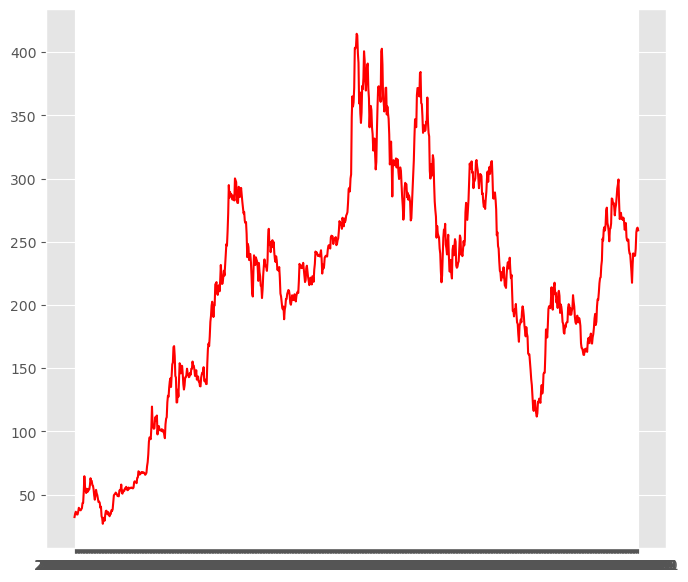

In [ ]:
# Visualising the results
plt.plot(df.loc[1600:, 'date'],dataset_test.values, color = 'red', label = 'Real TESLA Stock Price')
plt.plot(df.loc[1600:, 'date'],predicted_stock_price, color = 'blue', label = 'Predicted TESLA Stock Price')
plt.xticks(np.arange(0,459,50))
plt.title('TESLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TESLA Stock Price')
plt.legend()
plt.show()

## Classification: BUY OR SELL

## Conclusion

In [ ]:
#@title Load Python libraries

! pip install alpha_vantage -q

# pip install numpy
import numpy as np

# pip install torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# pip install matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# pip install alpha_vantage
from alpha_vantage.timeseries import TimeSeries 

print("All libraries loaded")

All libraries loaded


Data preparation: acquiring financial market data from Alpha Vantage